# ライブラリのインポート
使うライブラリは最初にimportしましょう。具体的には次のセルのような感じです。

pythonにデフォルトで入ってる標準ライブラリは冒頭に書くお作法らしいです。
`pip`で入れるようなライブラリはその下に。
自作ライブラリは最後らしいですね。
（書き方の工夫なので無視してもいいと思いますが。）

In [1]:
import os, pickle,sys
from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Model,Sequential,layers,losses
import librosa

print(tf.__version__)

2.3.0


# データの読み込み・加工

In [2]:
base_dir=os.path.join('ESC-50-master','audio')
print(base_dir)
files=os.listdir(base_dir)
print('\n'.join(files[:10]))

df = pd.read_csv('./ESC-50-master/meta/esc50.csv')
categories = df['category']
cat_names = categories.unique()

ESC-50-master\audio
1-100032-A-0.wav
1-100038-A-14.wav
1-100210-A-36.wav
1-100210-B-36.wav
1-101296-A-19.wav
1-101296-B-19.wav
1-101336-A-30.wav
1-101404-A-34.wav
1-103298-A-9.wav
1-103995-A-30.wav


In [3]:
num_train=35
num_frames=512
strides=256

if not(os.path.exists('training_{}_{}.pickle'.format(num_frames,strides)) & os.path.exists('test_{}_{}.pickle'.format(num_frames,strides))):
  dataset_train = []
  label_train = []
  dataset_test=[]
  label_test=[]

  for cat_name in cat_names:
    boolean_mask = categories.str.contains(cat_name)
    files = df ['filename'][boolean_mask]
    for d,l,f in zip([dataset_train,dataset_test],[label_train,label_test],[files[:num_train],files[num_train:]]):
      for file in f:
        y,sr = librosa.load(os.path.join(base_dir,file))
        num_frames_per_data=y.shape[0]
        d.append(
          np.concatenate([y[np.newaxis,i*strides:i*strides+num_frames,np.newaxis] for i in range((num_frames_per_data-num_frames)//strides+1)],axis=0)
        )
        l.append([cat_name]*((num_frames_per_data-num_frames)//strides+1))
  label_train = np.asarray(list(chain(*label_train)))
  label_test = np.asarray(list(chain(*label_test)))
  dataset_train = np.concatenate(dataset_train,axis=0)
  dataset_test = np.concatenate(dataset_test,axis=0)
  with open('training_{}_{}.pickle'.format(num_frames,strides),'wb') as f:
    pickle.dump(dataset_train,f)
    pickle.dump(label_train,f)  
  with open('test_{}_{}.pickle'.format(num_frames,strides),'wb') as f:
    pickle.dump(dataset_test,f)
    pickle.dump(label_test,f)
else:
  with open('training_{}_{}.pickle'.format(num_frames,strides),'rb') as f:
    dataset_train = pickle.load(f)
    label_train = pickle.load(f)  
  with open('test_{}_{}.pickle'.format(num_frames,strides),'rb') as f:
    dataset_test = pickle.load(f)
    label_test = pickle.load(f)

`'{}'.format(variable)`は`printf("%d",variable)`です。
```python
a=10.0
b=5.0
print('a is equal to {:}'.format(a))
print('a is equal to {:.2f}'.format(a))
print('b is equal to {1:} and a is equal to {0:}'.format(a,b))
```

ファイル名にパラメータを入れることで、データセットを複数種類作るために以下のセルでは使っています。

一番外側の`if`文はすでにデータセットが存在しているかを見ています。

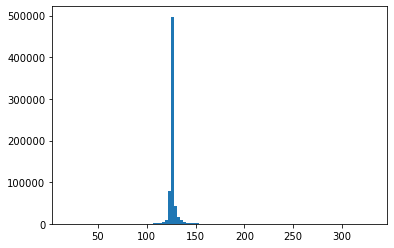

In [4]:
d_norm=np.sum(dataset_train**2,axis=(1,2))
filt=(d_norm!=0)
dataset_train=np.compress(filt,dataset_train,axis=0)
label_train = np.compress(filt,label_train,axis=0)

d_norm=np.sum(dataset_test**2,axis=(1,2))
filt=(d_norm!=0)
dataset_test=np.compress(filt,dataset_test,axis=0)
label_test = np.compress(filt,label_test,axis=0)


max_val=np.max(dataset_train)
min_val=np.min(dataset_train)
dataset_train = (dataset_train-min_val)/(max_val-min_val)
dataset_test = (dataset_test-min_val)/(max_val-min_val)

plt.hist(np.sum(dataset_train**2,axis=(1,2)),bins=100)
plt.show()

完全に無音のデータを弾いています。
そのあとで最大最小を用いてスケーリング。

In [5]:
class ConvAE(Model):
  def __init__(self,latent_dim):
    num_frames=512
    num_conv1d=3 #encoderで3回畳み込みをしていることに対応
    filters=32
    num_start = num_frames//(2**num_conv1d) # 2はここではstridesの値
    super(ConvAE,self).__init__()
    self.encoder=Sequential([
      layers.InputLayer((num_frames,1)),
      layers.Conv1D(filters=8,kernel_size=3,strides=2,padding='same',activation='relu'),
      layers.Conv1D(filters=16,kernel_size=3,strides=2,padding='same',activation='relu'),
      layers.Conv1D(filters=filters,kernel_size=3,strides=2,padding='same',activation='relu'),
      layers.Flatten(),
      layers.Dense(latent_dim,activation='selu')
    ])
    self.decoder=Sequential([
      layers.InputLayer((latent_dim,)),
      layers.Dense(num_start*filters,activation='selu'),
      layers.Reshape((num_start,filters)),
      layers.Conv1DTranspose(filters=16,kernel_size=3,strides=2,padding='same',activation='selu'),
      layers.Conv1DTranspose(filters=8,kernel_size=3,strides=2,padding='same',activation='selu'),
      layers.Conv1DTranspose(filters=1,kernel_size=3,strides=2,padding='same',activation='selu'),
    ])
                       
  def call(self,x):
    return self.decoder(self.encoder(x))
  def encode(self,x):
    return self.encoder(x)

In [39]:
class VariationalConvAE(Model):
  def __init__(self,latent_dim):
    num_frames=512
    num_conv1d=3 #encoderで3回畳み込みをしていることに対応
    filters=32
    num_start = num_frames//(2**num_conv1d) # 2はここではstridesの値
    super(VariationalConvAE,self).__init__()
    self.encoder=Sequential([
      layers.InputLayer((num_frames,1)),
      layers.Conv1D(filters=8,kernel_size=3,strides=2,padding='same',activation='relu'),
      layers.Conv1D(filters=16,kernel_size=3,strides=2,padding='same',activation='relu'),
      layers.Conv1D(filters=filters,kernel_size=3,strides=2,padding='same',activation='relu'),
      layers.Flatten(),
      layers.Dense(latent_dim,activation='selu')
    ])
    self.decoder=Sequential([
      layers.InputLayer((latent_dim,)),
      layers.Dense(num_start*filters,activation='selu'),
      layers.Reshape((num_start,filters)),
      layers.Conv1DTranspose(filters=16,kernel_size=3,strides=2,padding='same',activation='selu'),
      layers.Conv1DTranspose(filters=8,kernel_size=3,strides=2,padding='same',activation='selu'),
      layers.Conv1DTranspose(filters=1,kernel_size=3,strides=2,padding='same',activation='selu'),
    ])
                       
  def call(self,x):
    return self.decoder(self.encoder(x))
  def encode(self,x):
    return self.encoder(x)

1次元の畳み込みニューラルネットワークの定義をしています。

まずは`lat_dim`で回して結果をとってから、ですが、ここは後でいろいろ変えてみてください。


In [40]:
ds_train_tensor = tf.data.Dataset.from_tensor_slices((dataset_train,dataset_train)).shuffle(dataset_train.shape[0]).batch(2048)
ds_test_tensor = tf.data.Dataset.from_tensor_slices((dataset_test,dataset_test)).batch(2048)

In [34]:
lat_dim_list=[16,32,64,128]
model_list=[]
mse_list=[]

#check_point_path_template='training_lat_dim_{}/cp.ckpt'
check_point_path_template="training_model_{}_lat_dim_{}/cp.ckpt"

for lat_dim in lat_dim_list:
  tf.keras.backend.clear_session()

  check_point_path=check_point_path_template.format('ConvAE',lat_dim)
  check_point_dir = os.path.dirname(check_point_path,)
  cp_callback = tf.keras.callbacks.ModelCheckpoint(check_point_path,save_weights_only=True,verbose=1)

  model=ConvAE(lat_dim)
  #model=VariationalConvAE(lat_dim)
  model.compile(optimizer='adam',loss=losses.MeanSquaredError())
  model.fit(
    x=ds_train_tensor,
    epochs=10,
    validation_data=ds_test_tensor,
    callbacks=[cp_callback]
  )
  mse=model.evaluate(ds_test_tensor)
  mse_list.append(mse)

KeyboardInterrupt: 

In [41]:
lat_dim_list=[16,32,64,128]
model_list=[]
mse_list=[]

#check_point_path_template='training_lat_dim_{}/cp.ckpt'
check_point_path_template="training_model_{}_lat_dim_{}/cp.ckpt"

for lat_dim in lat_dim_list:
  tf.keras.backend.clear_session()

  check_point_path1 = check_point_path_template.format('VariationalConvAE',lat_dim)
  check_point_dir = os.path.dirname(check_point_path1,)
  cp_callback = tf.keras.callbacks.ModelCheckpoint(check_point_path1,save_weights_only=True,verbose=1)

  model=VariationalConvAE(lat_dim)
  #model=VariationalConvAE(lat_dim)
  model.compile(optimizer='adam',loss=losses.MeanSquaredError())
  model.fit(
    x=ds_train_tensor,
    epochs=10,
    validation_data=ds_test_tensor,
    callbacks=[cp_callback]
  )
  mse=model.evaluate(ds_test_tensor)
  mse_list.append(mse)

Epoch 1/10
367/367 [==============================] - ETA: 0s - loss: 0.0118
Epoch 00001: saving model to training_model_VariationalConvAE_lat_dim_16\cp.ckpt
367/367 [==============================] - 19s 53ms/step - loss: 0.0118 - val_loss: 0.0031
Epoch 2/10
367/367 [==============================] - ETA: 0s - loss: 0.0112
Epoch 00002: saving model to training_model_VariationalConvAE_lat_dim_16\cp.ckpt
367/367 [==============================] - 19s 53ms/step - loss: 0.0112 - val_loss: 0.0021
Epoch 3/10
367/367 [==============================] - ETA: 0s - loss: 0.0112
Epoch 00003: saving model to training_model_VariationalConvAE_lat_dim_16\cp.ckpt
367/367 [==============================] - 19s 53ms/step - loss: 0.0112 - val_loss: 0.0021
Epoch 4/10
367/367 [==============================] - ETA: 0s - loss: 0.0111
Epoch 00004: saving model to training_model_VariationalConvAE_lat_dim_16\cp.ckpt
367/367 [==============================] - 19s 53ms/step - loss: 0.0111 - val_loss: 0.0019
Epoc

Epoch 4/10
367/367 [==============================] - ETA: 0s - loss: 0.0085
Epoch 00004: saving model to training_model_VariationalConvAE_lat_dim_32\cp.ckpt
367/367 [==============================] - 21s 57ms/step - loss: 0.0085 - val_loss: 0.0017
Epoch 5/10
367/367 [==============================] - ETA: 0s - loss: 0.0085
Epoch 00005: saving model to training_model_VariationalConvAE_lat_dim_32\cp.ckpt
367/367 [==============================] - 21s 56ms/step - loss: 0.0085 - val_loss: 0.0015
Epoch 6/10
367/367 [==============================] - ETA: 0s - loss: 0.0085
Epoch 00006: saving model to training_model_VariationalConvAE_lat_dim_32\cp.ckpt
367/367 [==============================] - 21s 56ms/step - loss: 0.0085 - val_loss: 0.0015
Epoch 7/10
367/367 [==============================] - ETA: 0s - loss: 0.0085
Epoch 00007: saving model to training_model_VariationalConvAE_lat_dim_32\cp.ckpt
367/367 [==============================] - 21s 58ms/step - loss: 0.0085 - val_loss: 0.0017
Epoc

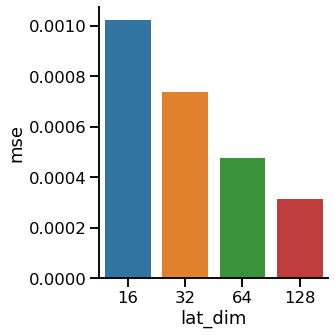

In [10]:
df=pd.DataFrame(data={'lat_dim':lat_dim_list,'mse':mse_list})
sns.set_context('talk')
sns.catplot(data=df,x='lat_dim',y='mse',kind='bar')
plt.show()

lat_dim=16


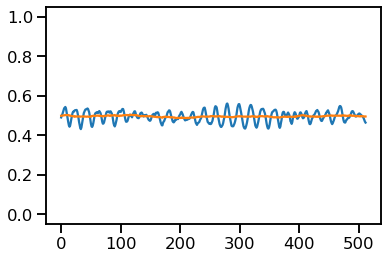

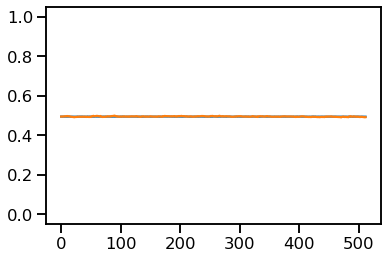

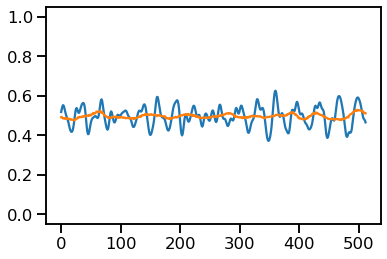

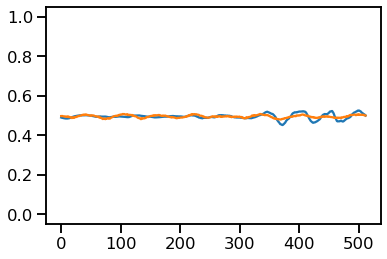

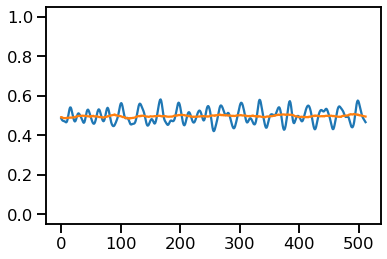

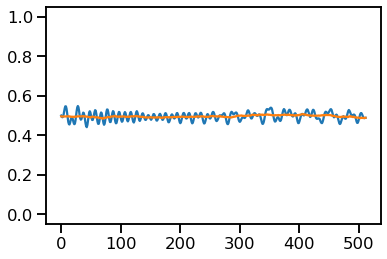

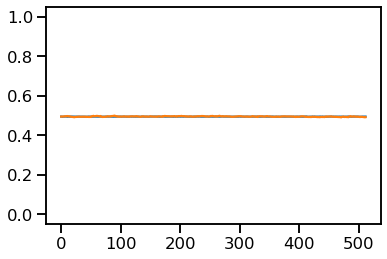

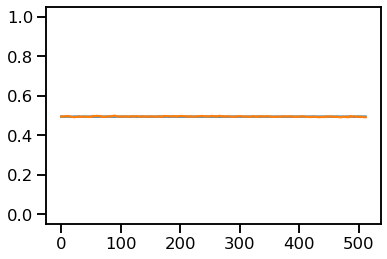

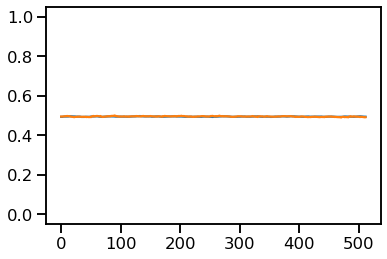

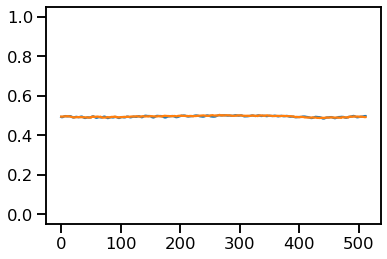

lat_dim=32


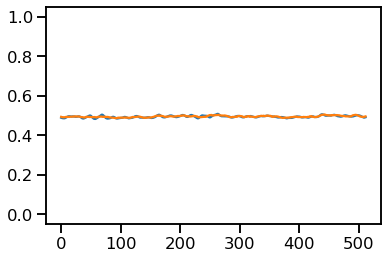

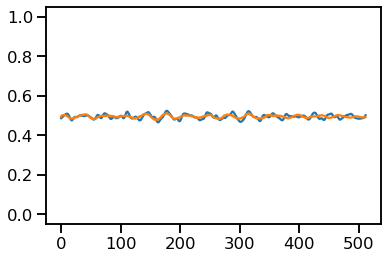

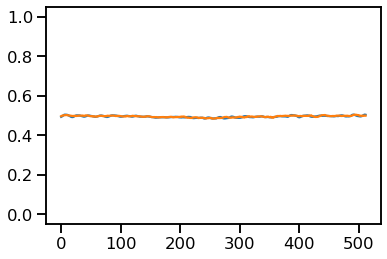

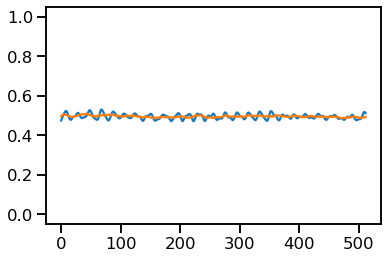

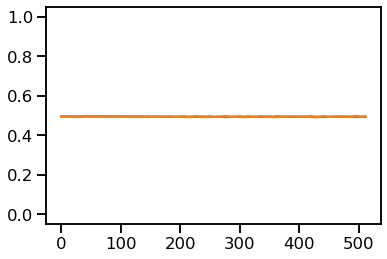

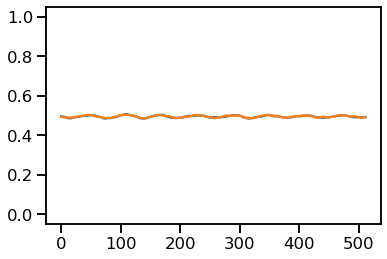

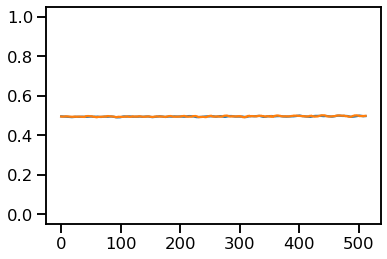

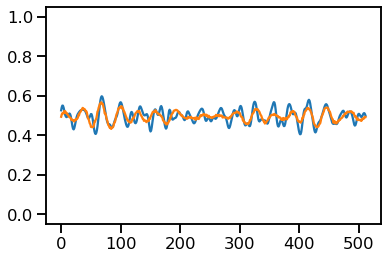

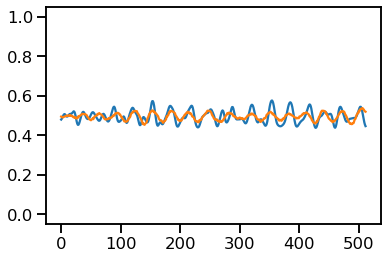

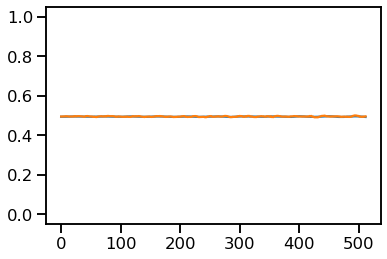

lat_dim=64


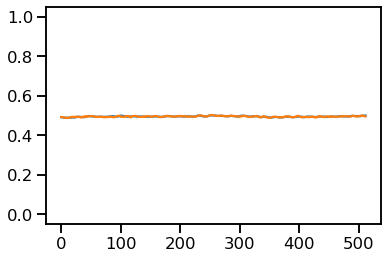

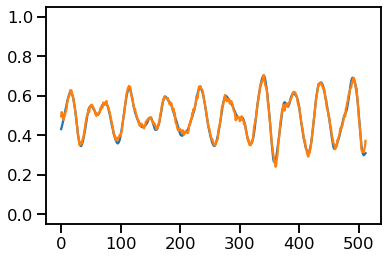

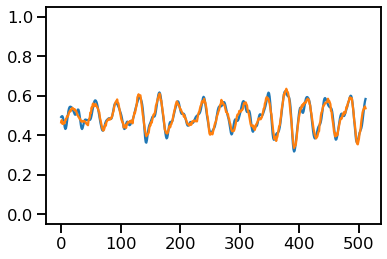

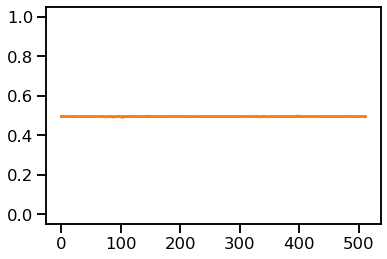

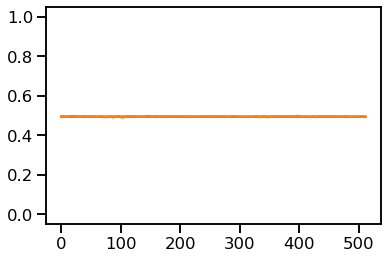

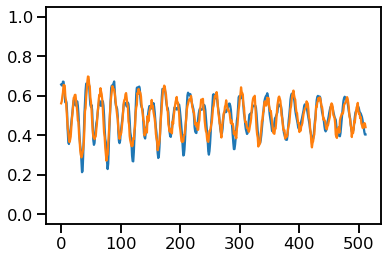

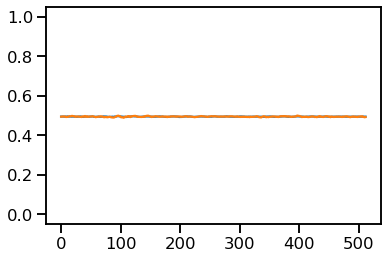

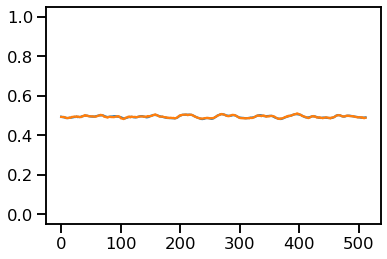

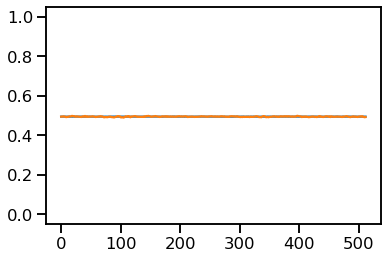

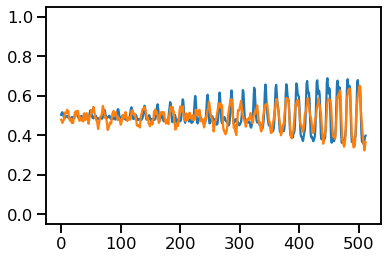

lat_dim=128


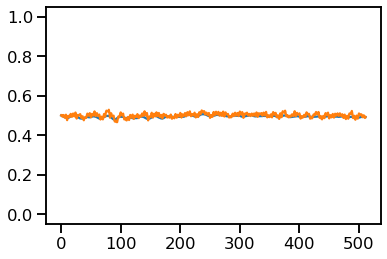

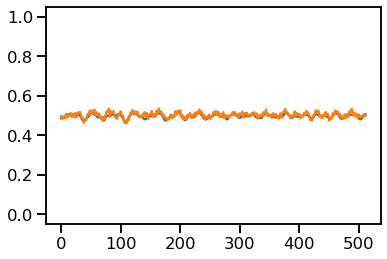

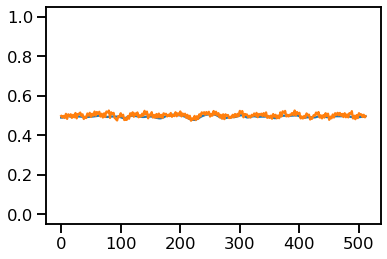

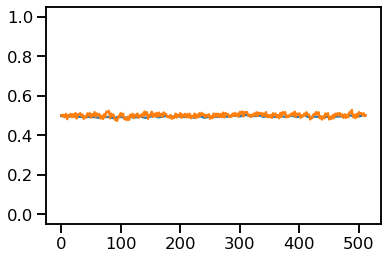

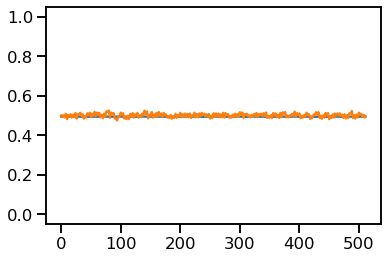

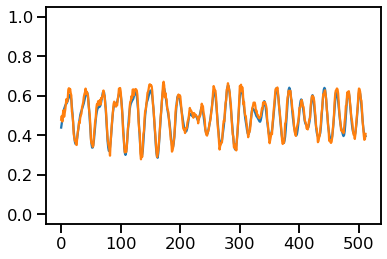

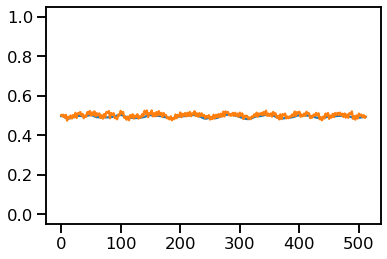

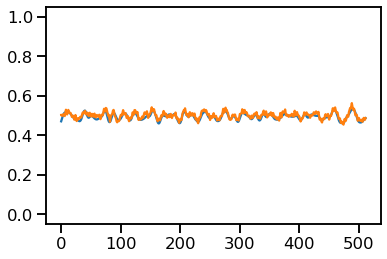

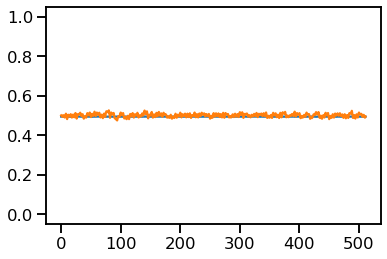

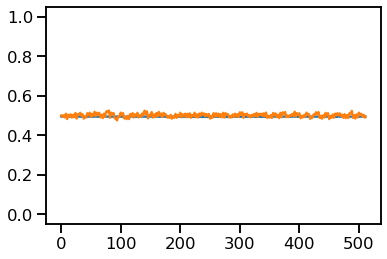

In [11]:
for lat_dim in lat_dim_list:
  print('lat_dim={}'.format(lat_dim))
  tf.keras.backend.clear_session()

  check_point_path=check_point_path_template.format('ConvAE',lat_dim)
  check_point_dir = os.path.dirname(check_point_path,)
  cp_callback = tf.keras.callbacks.ModelCheckpoint(check_point_path,save_weights_only=True,verbose=1)

  model_plot=ConvAE(lat_dim)
  model_plot.load_weights(check_point_path)
  xx,_ = next(ds_test_tensor.__iter__())
  xx_recon = model_plot(xx)
  for i in np.random.permutation(2048)[:10]:
    plt.plot(xx[i])
    plt.plot(xx_recon[i])
    plt.ylim([-0.05,1.05])
    plt.show()

In [12]:

model.decoder.summary() 


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              132096    
_________________________________________________________________
reshape (Reshape)            (None, 64, 16)            0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 128, 16)           784       
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 256, 8)            392       
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 512, 1)            25        
Total params: 133,297
Trainable params: 133,297
Non-trainable params: 0
_________________________________________________________________


In [13]:
dataset_test.shape

(114029, 512, 1)

In [42]:
with open('training_{}_{}.pickle'.format(num_frames,strides),'rb') as f:
  dataset_train = pickle.load(f)
  label_train = pickle.load(f)  
max_val=np.max(dataset_train)
min_val=np.min(dataset_train)

In [43]:
with open('train_feature_for_decision_tree.pickle','rb') as f:
  x=pickle.load(f)
with open('train_label_for_decision_tree.pickle','rb') as f:
  y=pickle.load(f)
with open('test_data_for_decision_tree.pickle','rb') as f:
  x_test=pickle.load(f)
with open('test_label_for_decision_tree.pickle','rb') as f:
  y_test=pickle.load(f)
x=(x-min_val)/(max_val-min_val)
x_test=(x_test-min_val)/(max_val-min_val)

ds = tf.data.Dataset.from_tensor_slices(x)
ds_test=tf.data.Dataset.from_tensor_slices(x_test)

#model=ConvAE(lat_dim) 
#model.load_weights(check_point_path,'./training_model_ConvAE_lat_dim_16')
model=VariationalConvAE(lat_dim) 
model.load_weights(check_point_path1)

features_train=[]
features_test=[]

for d in ds:
    features=model.encoder(d)
    features_train.append(features)
for d in ds_test:
    features=model.encoder(d)
    features_test.append(features)  

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import confusion_matrix

features_train=[]
features_test=[]
for d in ds:
    features=model(d)
    features_train.append(features.numpy()[np.newaxis,:,:])
for d in ds_test:
    features=model(d)
    features_test.append(features.numpy()[np.newaxis,:,:]) 
    
x=np.concatenate(features_train,axis=0)
x_test=np.concatenate(features_test,axis=0)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=y.shape[0]//100*95, random_state=1)

tree_prop = DecisionTreeClassifier(max_depth=10,)
tree_prop.fit(X_train.reshape([X_train.shape[0],-1]).astype(np.float),y_train.ravel().astype(np.int))
print('finish_fit')

y_pred=tree_prop.predict(x_test.reshape([x_test.shape[0],-1]).astype(np.float))
cfm=confusion_matrix(y_test,y_pred,labels=[1,0])
tp,fn,fp,tn=cfm.ravel()
print(cfm)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

finish_fit
[[ 729 1125]
 [3236 7382]]


In [ ]:
df=pd.DataFrame(data={'lat_dim':lat_dim_list,'mse':mse_list})
sns.set_context('talk')
sns.catplot(data=df,x='lat_dim',y='mse',kind='bar')
plt.show()

In [10]:
idx=0
y_recon=ConvAutoencoder(dataset_test_tensor[:1000])
for idx in range(0,1000,10):
  plt.plot(dataset_test_tensor[idx,:,0])
  plt.plot(y_recon.numpy()[idx,:,0])
  plt.ylim([0,1])
  plt.show()

NameError: name 'ConvAutoencoder' is not defined

In [ ]:
cat_names_human = np.array([
  'crying_baby','sneezing','clapping','breathing','coughing','footsteps','laughing','brushing_teeth','snoring','drinking_sipping'
])

In [ ]:
dataset_train_tensor = np.concatenate(dataset_train,axis=0)
dataset_test_tensor = np.concatenate(dataset_test,axis=0)

In [ ]:
dataset_train_tensor=(dataset_train_tensor-min_val)/(max_val-min_val)

In [ ]:
for _,y in zip(range(10),dataset_train_tensor):
  print(y.shape)
  plt.plot(y[:,0])
  plt.show()